In [1]:
import collections
import glob
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats

dataset_dir = "../data_prep/final_dataset/"

SUBSETS = "train dev test".split()

datasets = collections.defaultdict(list)

for subset in SUBSETS:
    for filename in glob.glob(dataset_dir + subset + "/*"):
        with open(filename, 'r') as f:
            datasets[subset].append(json.load(f))
            
all_pairs = sum(datasets.values(), [])

DPI = 150


FigText = collections.namedtuple("c", "x y text ha va rotation".split())
plt.rcParams.update({'font.size':'28',
                     'hatch.color': 'w'})

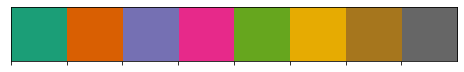

In [2]:
palette = sns.color_palette("Dark2")
OVERALL_IDX, EVAL_IDX, REQ_IDX, FACT_IDX,STRUCT_IDX,  OTHER_IDX, SOCIAL_IDX, AUX_IDX = range(8)
sns.palplot(palette)

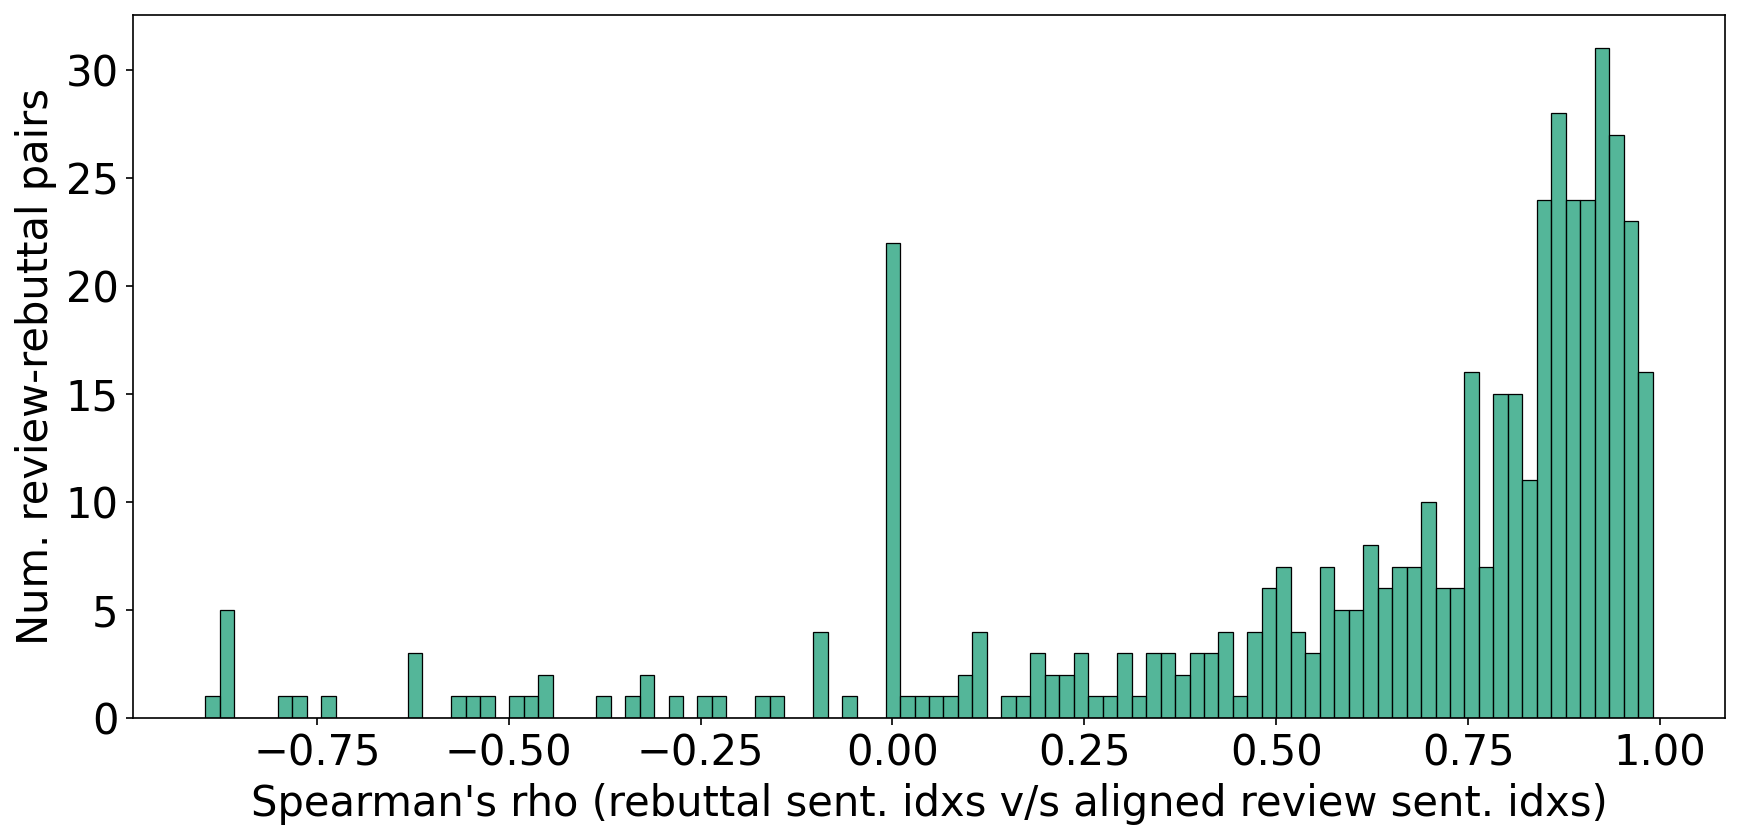

In [16]:
spearmen = []
for pair in all_pairs:
    alignment_list = []
    for sentence in pair["rebuttal_sentences"]:
        align_type, align_indices = sentence["alignment"]
        if align_type == "context_sentences":
            for review_index in align_indices:
                alignment_list.append([sentence["sentence_index"], review_index])
    if not alignment_list:
        continue
    a, b = zip(*alignment_list)
    if len(set(a)) == 1 or len(set(b)) == 1:
        continue
    spearmen.append(stats.spearmanr(*zip(*alignment_list)).correlation)    

plt.figure(figsize=(12, 6), dpi=DPI)
fig = sns.histplot(spearmen, bins=100, color=palette[OVERALL_IDX])
plt.ylabel("Num. review-rebuttal pairs")
plt.xlabel("Spearman's rho (rebuttal sent. idxs v/s aligned review sent. idxs)")

plt.tight_layout()

plt.savefig("figs/spearmen.pdf")



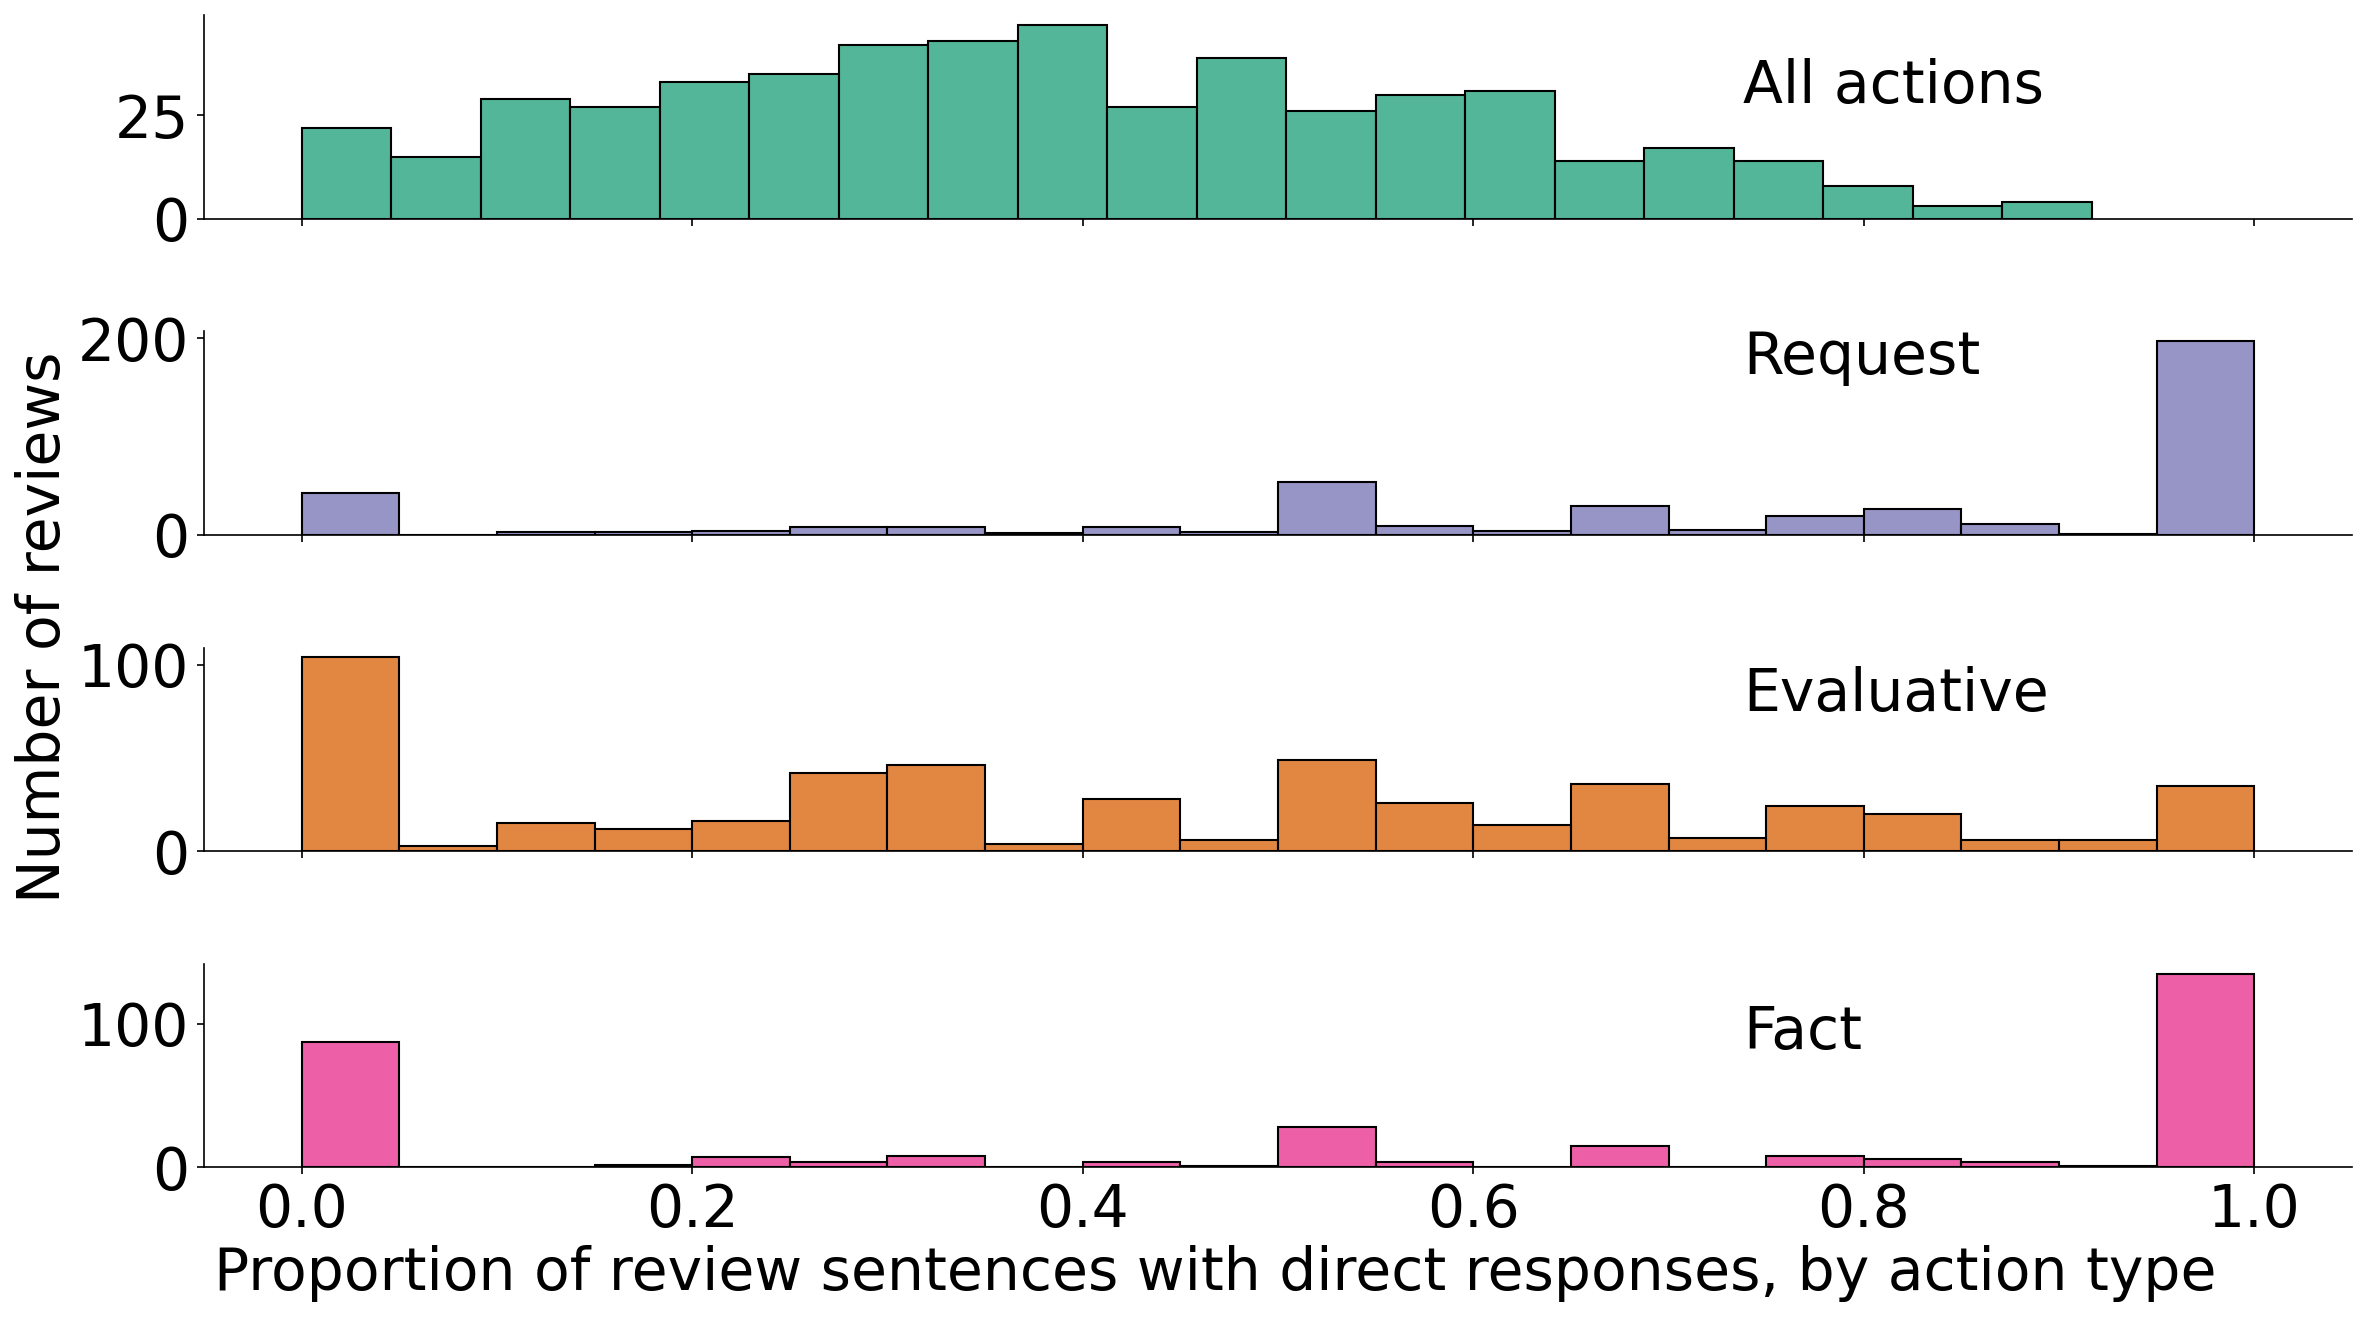

In [4]:
review_sentence_counter = {}

for pair in all_pairs:
    review_id = pair["metadata"]["review_id"]
    review_sentence_counter[review_id] = {
        "mapped": [False]* len(pair["review_sentences"]),
        "arg_type": [sentence["coarse"] for sentence in pair["review_sentences"]]}
    for rebuttal_sentence in pair["rebuttal_sentences"]:
        align_type, aligned = rebuttal_sentence["alignment"]
        if align_type == "context_sentences":
            for index in aligned:
                try:
                    review_sentence_counter[review_id]["mapped"][index] = True
                except IndexError:
                    pass
                
#color_list = [OVERALL_COLOR, REQUEST_COLOR, EVAL_COLOR, FACT_COLOR]
color_indices = [OVERALL_IDX, REQ_IDX, EVAL_IDX, FACT_IDX]

fig, axs = plt.subplots(4, 1, figsize=(16,9), sharex=True, dpi=DPI)

coverages = []
for review_id, mappyloo in review_sentence_counter.items():
    coverages.append(sum(mappyloo["mapped"])/len(mappyloo["mapped"]))
sns.histplot(coverages, ax=axs[0], bins=20, color=palette[OVERALL_IDX])

axs[0].yaxis.label.set_visible(False)

for i, arg_type in enumerate("overall request evaluative fact".split()):
    if i == 0:
        continue
    actual_arg_type = "arg_" + arg_type

    coverages = []
    for review_id, mappyloo in review_sentence_counter.items():
        filtered = [mappyloo["mapped"][j] for j, t in enumerate(mappyloo["arg_type"]) if t == actual_arg_type]
        if not filtered:
            continue
        coverages.append(sum(filtered)/len(filtered))


    sns.histplot(coverages, ax=axs[i], bins=20, color=palette[color_indices[i]])

    
y_axis_label = FigText(0.0, 0.5, "Number of reviews", "left", "center", "vertical")
x_axis_label = FigText(0.5, 0.0,
                       'Proportion of review sentences with direct responses, by action type',
                       "center", "bottom", "horizontal")
plot_labels = [
    x_axis_label, y_axis_label,
    FigText(0.72, 0.7, 'Request', "left", "center", "horizontal"),
    FigText(0.72, 0.45, 'Evaluative', "left", "center", "horizontal"),
    FigText(0.72, 0.2, 'Fact', "left", "center", "horizontal"),
    FigText(0.72, 0.9, 'All actions', "left", "center", "horizontal"),
]


for ft in plot_labels:
    fig.text(ft.x, ft.y, ft.text, ha=ft.ha, va=ft.va, rotation=ft.rotation)

for i in range(4):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].yaxis.label.set_visible(False)

plt.tight_layout()
plt.savefig("figs/coverage.pdf")



Needs attention:  28
Total:  159


,agg,rating
agg,1.000000,0.346783
rating,0.346783,1.000000


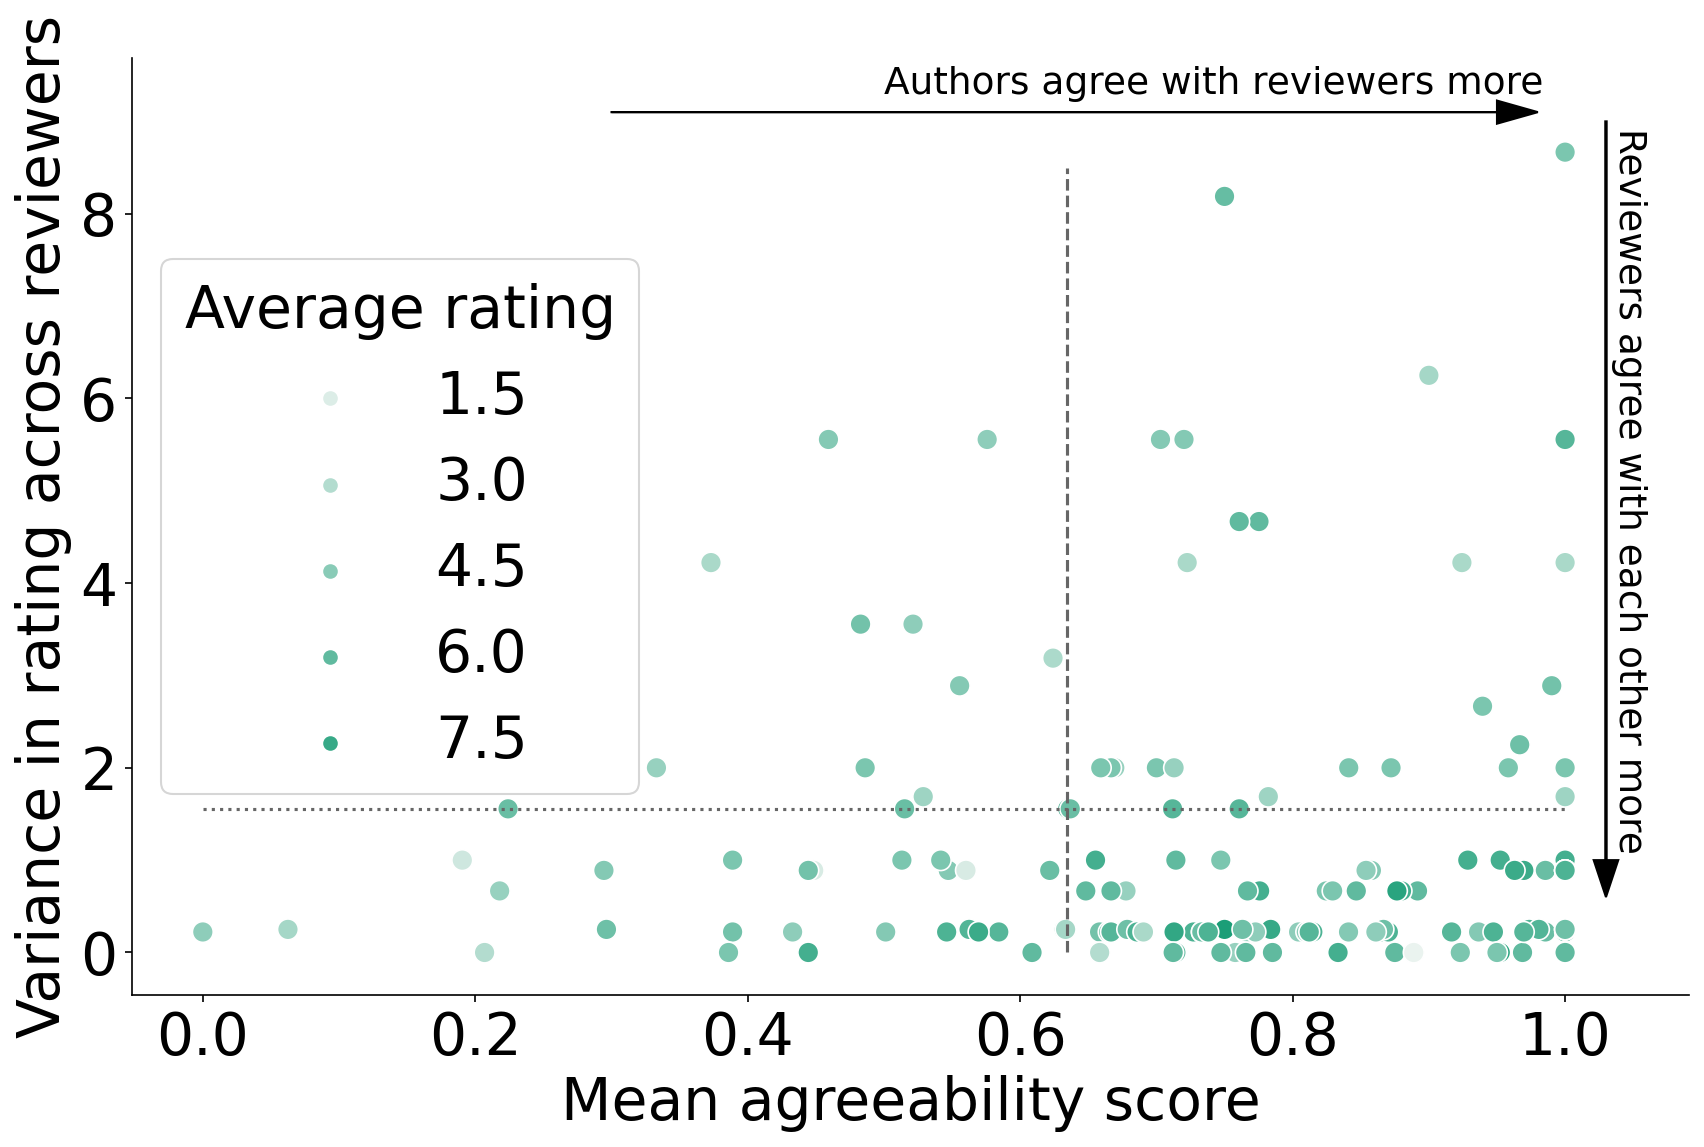

In [5]:
# Agreeability v/s variance

import numpy as np

def get_agreeability(pair_obj):
    coarse_counter = collections.Counter()
    for sentence in pair_obj["rebuttal_sentences"]:
        coarse_counter[sentence['coarse']] += 1
    if 'concur' not in coarse_counter and 'dispute' not in coarse_counter:
        return {'agreeability': None}
    return {
      "agreeability":
        coarse_counter['concur'] / (coarse_counter['concur'] + coarse_counter['dispute'])
    }

def draw_constant_line(value, other_axis_values, is_horizontal):
    pass

forum_agreeability_map = collections.defaultdict(list)

for pair in all_pairs:
    forum_agreeability_map[pair["metadata"]["forum_id"]].append((get_agreeability(pair)["agreeability"],pair["metadata"]["rating"] ))

agreeability_df_dicts = []



# Column names
agree_mean, rating_var, avg_rating = ["Mean agreeability score", "Variance in rating across reviewers", "Average rating"]
    
for forum, info in forum_agreeability_map.items():
    if len(info) == 1:
        continue
    agreeabilities, ratings = list(zip(*info))
    if None in agreeabilities:
        continue
    agreeability_df_dicts.append({agree_mean: np.mean(agreeabilities),
                                 rating_var: np.var(ratings),
                                 avg_rating: np.mean(ratings)})
    
agreeability_df = pd.DataFrame.from_dict(agreeability_df_dicts)

agreeability_first_quartile = agreeability_df.quantile(0.25)[agree_mean]
variance_third_quartile = agreeability_df.quantile(0.75)[rating_var]

print("Needs attention: ", len([p for p in agreeability_df_dicts if (p[agree_mean] < agreeability_first_quartile and p[rating_var] < variance_third_quartile)]))
print("Total: ", len(agreeability_df_dicts))

plt.figure(figsize=(12, 8), dpi=DPI)
ax = sns.scatterplot(
    data=agreeability_df,
    x=agree_mean,
    y=rating_var,
    hue=avg_rating, s=100,palette=sns.light_palette(palette[OVERALL_IDX], as_cmap=True))
plt.plot([agreeability_first_quartile,agreeability_first_quartile], [0,8.5], linestyle="dashed", color=palette[AUX_IDX])
plt.plot([0,1], [variance_third_quartile,variance_third_quartile], linestyle="dotted", color=palette[AUX_IDX])


plot_labels = [
    FigText(0.5, 9.4, 'Authors agree with reviewers more', "left", "center", "horizontal"),
    FigText(1.06, 5, "Reviewers agree with each other more", "right", "center", 270)
]


ax.arrow(0.3, 9.1, 0.65,0, head_width=0.25, head_length=0.03, fc='k', ec='k')

ax.arrow(1.03, 9, 0, -8, head_width=0.018, head_length=0.4, fc='k', ec='k')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for ft in plot_labels:
    plt.text(ft.x, ft.y, ft.text, ha=ft.ha, va=ft.va, rotation=ft.rotation, fontdict={"size":18})
    

plt.tight_layout()
plt.savefig("figs/agreeability.pdf")

corr_df = pd.DataFrame.from_dict([{"agg":a, "rating":b} for a, b in sum(forum_agreeability_map.values(), [])])

corr_df.corr()



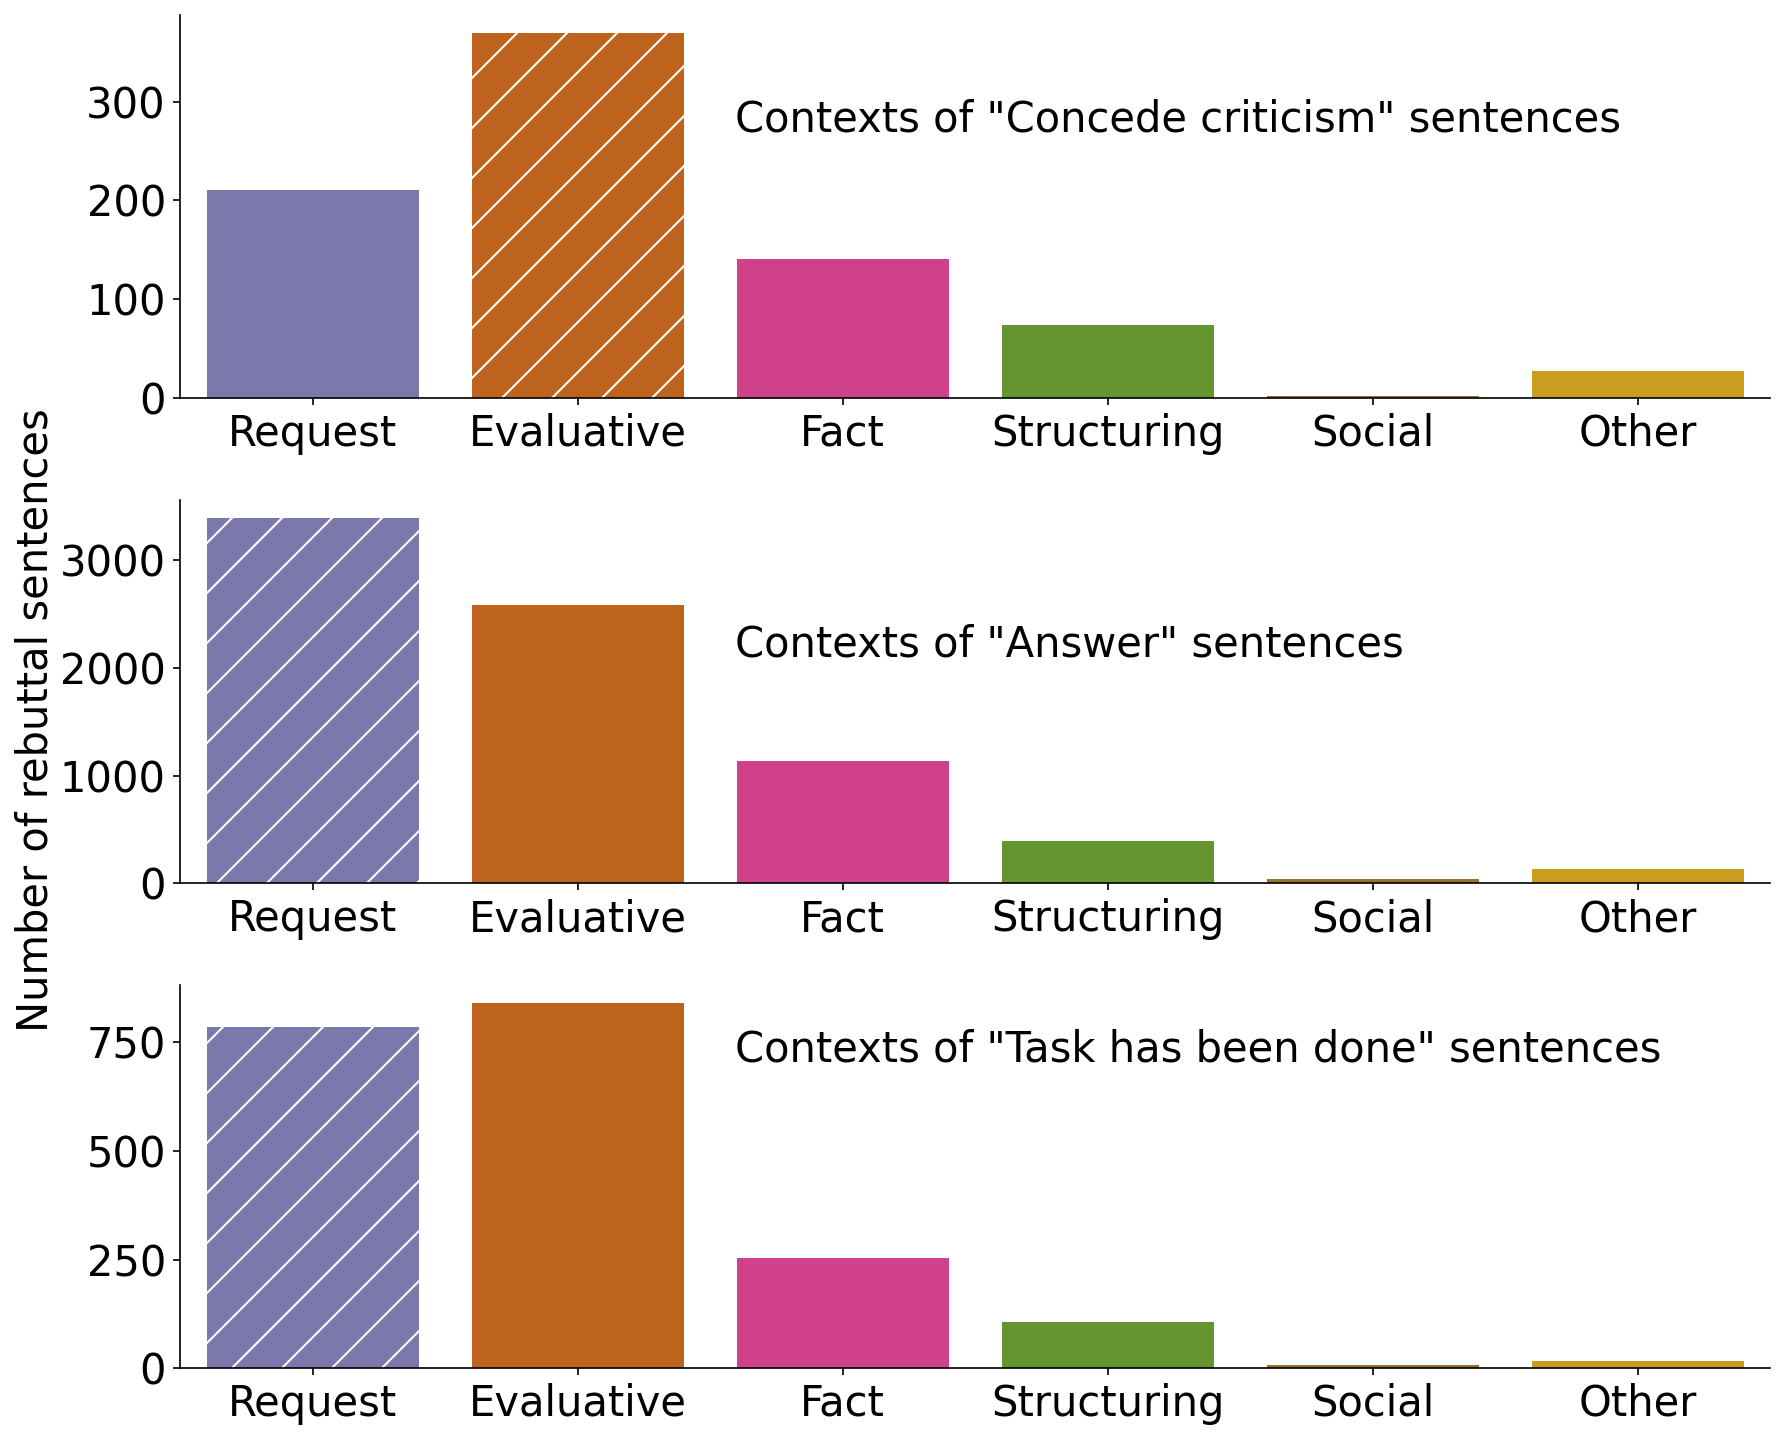

In [6]:

j = collections.defaultdict(lambda:collections.Counter())

for example in all_pairs:
    review_coarse_labels = [sentence["coarse"] for sentence in example["review_sentences"]]
    for rebuttal_sentence in example["rebuttal_sentences"]:
        fine = rebuttal_sentence["fine"]
        align_type, aligned_idxs = rebuttal_sentence["alignment"]
        if align_type == "context_sentences":
            for aligned_idx in rebuttal_sentence["alignment"][1]:
                try:
                    j[fine][review_coarse_labels[aligned_idx]] += 1
                except IndexError:
                    pass

review_types = "arg_request arg_evaluative arg_fact arg_structuring arg_social arg_other".split()
colors = [palette[i] for i in [REQ_IDX, EVAL_IDX, FACT_IDX, STRUCT_IDX, SOCIAL_IDX, OTHER_IDX]]

type_name_map = {
    "arg_request": "Request",
    "arg_evaluative": "Evaluative",
    "arg_fact": "Fact",
    "arg_social": "Social",
    "arg_structuring": "Structuring",
    "arg_other": "Other",
}

full_eval_responses = [
    "rebuttal_accept-praise",
"rebuttal_concede-criticism",
"rebuttal_mitigate-criticism",
"rebuttal_reject-criticism",
]

full_request_responses = [
    "rebuttal_answer",
"rebuttal_by-cr",
"rebuttal_done",
"rebuttal_future",
"rebuttal_refute-question",
"rebuttal_reject-request",
]

eval_responses = [
"rebuttal_concede-criticism",
]

request_responses = [
    "rebuttal_answer",
"rebuttal_done",
]



plt.rcParams.update({'font.size':20})

fig, axes = plt.subplots(nrows=len(eval_responses + request_responses), ncols=1, figsize=(12,10), dpi=DPI)

                     
ax_count = 0
for key in sorted(eval_responses) + sorted(request_responses):
    vals = j[key]
    bar = sns.barplot(x=[type_name_map[i] for i in review_types], y=[vals[i] for i in review_types],ax=axes[ax_count], palette=colors)
    
    if key in eval_responses:
        bar.patches[1].set_hatch("/")
    elif key in request_responses:
        bar.patches[0].set_hatch("/")
    else:
        assert False
    #bar.set_edgecolor([0.5,0.5,0.5])
    axes[ax_count].set_ylabel(key[9:])
    ax_count += 1
    

for i in range(3):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].yaxis.label.set_visible(False)

plot_labels = [
    FigText(0.4, 0.9, 'Contexts of "Concede criticism" sentences', "left", "center", "horizontal"),
    FigText(0.4, 0.55, 'Contexts of "Answer" sentences', "left", "center", "horizontal"),
    FigText(0.4, 0.28, 'Contexts of "Task has been done" sentences', "left", "center", "horizontal"),
    FigText(0.0, 0.5, "Number of rebuttal sentences", "left", "center", "vertical")
]


for ft in plot_labels:
    fig.text(ft.x, ft.y, ft.text, ha=ft.ha, va=ft.va, rotation=ft.rotation)
    
plt.tight_layout()
plt.savefig("figs/noncanonical.pdf")

In [7]:
overall_counter = collections.Counter()

for pair in all_pairs:
    for sentence in pair["review_sentences"]:
        overall_counter[sentence["coarse"]] +=1
        if sentence["coarse"] == "arg_evaluative":
            overall_counter[sentence["asp"]] += 1
        
        fine_val = sentence["fine"]
        if fine_val == 'none':
            continue
        overall_counter[fine_val] += 1

rebuttal_counter = collections.Counter()
for pair in all_pairs:
    for sentence in pair["rebuttal_sentences"]:
        rebuttal_counter[sentence["coarse"]] +=1
        
print(rebuttal_counter.most_common())
        
dists_info = [('Action: Evaluative', 1, EVAL_IDX, 3265),
('Aspect: Substance', 0, EVAL_IDX, 944),
('Aspect: Soundness', 0, EVAL_IDX, 660),
('Aspect: Clarity', 0, EVAL_IDX, 587),
('Aspect: Originality', 0, EVAL_IDX, 369),
('Aspect: Motivation', 0, EVAL_IDX, 342),
('Aspect: Comparison', 0, EVAL_IDX, 165),
('Aspect: Replicability', 0, EVAL_IDX, 131),
(' ', 0, EVAL_IDX, 0),
('Action: Structuring', 1, STRUCT_IDX, 2755),
('Fine: Summary', 0, STRUCT_IDX, 1807),
('Fine: Heading', 0, STRUCT_IDX, 849),
('Fine: Quote', 0, STRUCT_IDX, 99),
('  ', 0, EVAL_IDX, 0),
('Action: Request', 1, REQ_IDX, 1970),
('Fine: Explanation', 0, REQ_IDX, 547),
('Fine: Experiment', 0, REQ_IDX, 475),
('Fine: Edit', 0, REQ_IDX, 412),
('Fine: Clarification', 0, REQ_IDX, 278),
('Fine: Typo', 0, REQ_IDX, 196),
('Fine: Result', 0, REQ_IDX, 62),
('   ', 0, EVAL_IDX, 0),
('Action: Fact', 1, FACT_IDX, 850),
('    ', 0, EVAL_IDX, 0),
('Action: Other', 1, OTHER_IDX, 378),
('     ', 0, EVAL_IDX, 0),
('Action: Social', 1, SOCIAL_IDX, 140),
('     ', 0, EVAL_IDX, 0),
             ]

rebuttal_dist_info = [
('Rebuttal: Concur', 1, OVERALL_IDX, 5296),
('Rebuttal: Non-arg.', 1, OVERALL_IDX, 3995),
('Rebuttal: Dispute', 1, OVERALL_IDX, 1751),
('Rebuttal: Other', 1, OVERALL_IDX, 61),
             ]


[('concur', 5296), ('nonarg', 3995), ('dispute', 1751), ('other', 61)]


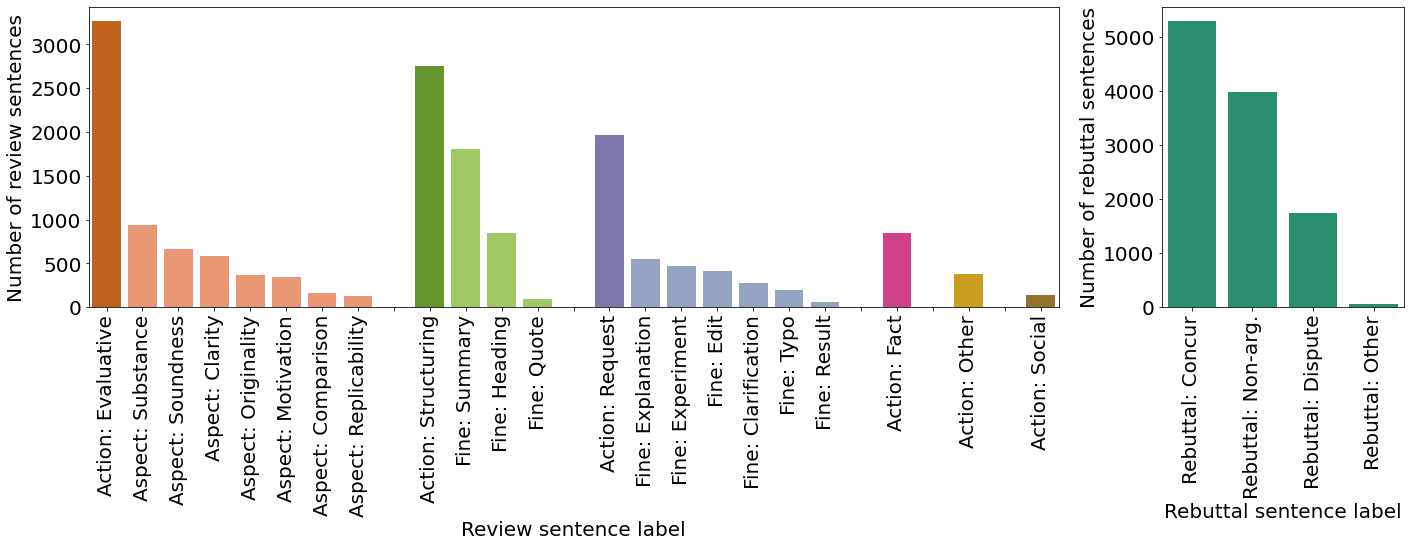

In [8]:
big_palette = palette + palette

palettes = [sns.color_palette("Set2"),sns.color_palette("Dark2")]

k = pd.DataFrame.from_dict([
    {"sent_type":name, "ct":ct, "color":palettes[palette_index][color_index] } for name, palette_index, color_index, ct in dists_info
])

p = pd.DataFrame.from_dict([
    {"sent_type":name, "ct":ct, "color":palettes[palette_index][color_index] } for name, palette_index, color_index, ct in rebuttal_dist_info
])




f, (a0, a1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [4, 1]})
bar = sns.barplot(x=k.sent_type, y=k.ct,palette=k.color,ax=a0)
bar = sns.barplot(x=p.sent_type, y=p.ct,palette=p.color,ax=a1)
a0.tick_params(axis="x", labelrotation=90)
a1.tick_params(axis="x", labelrotation=90)
a0.set_ylabel("Number of review sentences")
a0.set_xlabel("Review sentence label")
a1.set_ylabel("Number of rebuttal sentences")
a1.set_xlabel("Rebuttal sentence label")

plt.tight_layout()
plt.savefig("figs/dists.pdf")


<Figure size 900x900 with 0 Axes>

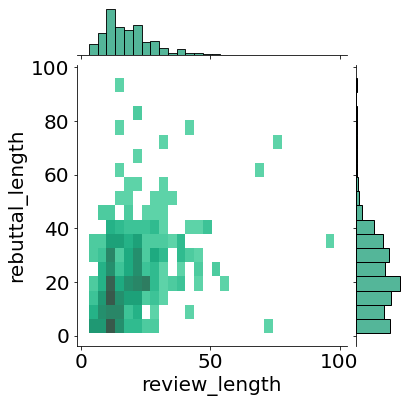

<Figure size 432x288 with 0 Axes>

In [9]:
# Review and rebuttal length

length_counter = collections.Counter()

for example in all_pairs:
    length_counter[(len(example["review_sentences"]), 
                    len(example["rebuttal_sentences"]))] += 1
df = pd.DataFrame.from_dict([
    {
        "review_length": a,
        "rebuttal_length": b,
        "count": count
    } for (a, b), count in length_counter.items()
])

plt.figure(figsize=(6,6), dpi=DPI)
sns.jointplot(x=df.review_length, y=df.rebuttal_length, color=palette[OVERALL_IDX], kind='hist')
plt.show()
plt.savefig('figs/reb-rev-len.pdf')

In [10]:
# Overlap types

from scipy.stats import entropy
import math

kappas = {"rev_fine": 0.6745764017866843,
"rev_coarse": 0.693987042777207, 
"rev_asp": 0.5572284555401004, 
"rev_pol": 0.6574618037925946,
"reb_fine": 0.5525445810438698,
"reb_coarse": 0.601743731682183,}

distribution_builder = collections.defaultdict(lambda:collections.Counter())

for example in datasets["train"]:
    for sentence in example["review_sentences"]:
        for k in "coarse fine asp pol".split():
            distribution_builder["rev_"+k][sentence[k]] += 1
    for sentence in example["rebuttal_sentences"]:
        for k in "coarse fine".split():
            distribution_builder["reb_"+k][sentence[k]] += 1

dicts = []
            
for label_set, counts in distribution_builder.items():
    dist = [k/sum(counts.values()) for k in counts.values()]
    dicts.append(
    {
        "label":label_set,
        "num_classes": len(counts),
        "entropy":entropy(dist, base=2),
        "kappa":kappas[label_set]
    })
    
r = pd.DataFrame.from_dict(dicts)

In [11]:
r

,label,num_classes,entropy,kappa
0,rev_coarse,6,2.114238,0.693987
1,rev_fine,10,2.327678,0.674576
2,rev_asp,9,2.418498,0.557228
3,rev_pol,4,1.797060,0.657462
4,reb_coarse,4,1.534525,0.601744
5,reb_fine,17,3.128550,0.552545


In [12]:
import nltk
from nltk.tokenize import word_tokenize

word_counters = collections.defaultdict(lambda : collections.Counter())

def count_tokens(sentences):
    token_count = 0
    for sentence in sentences:
        token_count += len(word_tokenize(sentence["text"]))
    return token_count

for subset, annotations in datasets.items():
    for annotation in annotations:
        for which_part in "review rebuttal".split():
            word_counters[subset][which_part] += count_tokens(annotation[which_part + "_sentences"])

print(word_counters)

defaultdict(<function <lambda> at 0x132ec7670>, {'train': Counter({'rebuttal': 131121, 'review': 110722}), 'dev': Counter({'rebuttal': 44222, 'review': 33089}), 'test': Counter({'rebuttal': 74129, 'review': 69447})})


In [13]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


False

In [14]:
print(len(all_pairs))

506


In [17]:
coarse_pol_counter = collections.defaultdict(lambda: collections.Counter())

for pair in all_pairs:
#     for sentence in pair["review_sentences"]:
#         for key in "coarse fine asp pol".split():
#             coarse_pol_counter["rev_"+key][sentence[key] == "none"] += 1
    for sentence in pair["rebuttal_sentences"]:
        coarse_pol_counter[sentence["fine"]][sentence["alignment"][0]] += 1
#         for key in "coarse fine".split():
#             coarse_pol_counter["reb_"+key][sentence[key] == "none"] += 1
    #coarse_pol_counter[sentence["coarse"]][sentence["asp"]] += 1
        
for k, v in coarse_pol_counter.items():
    print(k)
    for a, b in v.items():
        print("  ", a, b)
        

rebuttal_social
   context_global 601
   context_in-rebuttal 23
   context_sentences 115
   context_none 5
   context_error 1
rebuttal_structuring
   context_sentences 1601
   context_in-rebuttal 305
   context_global 42
   context_none 26
   context_error 4
rebuttal_summary
   context_sentences 769
   context_in-rebuttal 35
   context_none 19
   context_global 56
   context_error 3
rebuttal_other
   context_in-rebuttal 266
   context_global 29
   context_none 22
   context_sentences 34
   context_unknown 2
   context_error 2
rebuttal_reject-criticism
   context_sentences 1141
   context_global 3
   context_error 6
   context_unknown 1
rebuttal_refute-question
   context_sentences 105
rebuttal_answer
   context_sentences 3594
   context_error 10
   context_global 14
   context_unknown 1
   context_none 16
   context_in-rebuttal 2
rebuttal_done
   context_sentences 880
   context_global 36
   context_none 21
   context_unknown 7
   context_error 1
   context_in-rebuttal 8
rebuttal_by-cr